In [1]:
import pandas as pd
from preprocess import Audio_Processor
import data_utils as du
from sklearn import metrics
from keras.wrappers.scikit_learn import KerasClassifier
from classification_plots import plot_confusion_matrix, plot_learning_curve
import matplotlib.pyplot as plt
import os
import mdn
from sklearn.svm import SVC

Using TensorFlow backend.


In [2]:
# Able to specify which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="1"

SR = 44100
blocksize = 11025
overlap = 5512

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Setup

In [4]:
audio_dir = '../ESC-50/audio/'

In [5]:
path_to_db='../ESC-50/'
ps = Audio_Processor(path_to_db + 'audio/')

# Load Dataset
Here we load the csv that describes each file in the dataset. We add a high level category that is defined in the ESC-50 documentation. This we realize is anthetical to true training, it is a stopgap for when we use NLP to classify tags into these categories.

In [6]:
dataset = pd.read_csv(path_to_db + 'meta/esc50.csv')
classes = [None] * 50
h_classes = ['Human & Animal', 'Interacting Materials']

In [7]:
mapping = {
    'dog': 0,
    'rooster': 0,
    'pig': 0,
    'cow': 0,
    'frog': 0,
    'cat': 0,
    'hen': 0,
    'insects': 0,
    'sheep': 0,
    'crow': 0,
    'rain': 1,
    'sea_waves': 1,
    'crackling_fire': 1,
    'crickets': 0,
    'chirping_birds': 0,
    'water_drops': 1,
    'wind': 1,
    'pouring_water': 1,
    'toilet_flush': 1,
    'thunderstorm': 1,
    'crying_baby': 0,
    'sneezing': 0,
    'clapping': 0,
    'breathing': 0,
    'coughing': 0,
    'footsteps': 1,
    'laughing': 0,
    'brushing_teeth': 1,
    'snoring': 0,
    'drinking_sipping': 1,
    'door_wood_knock': 1,
    'mouse_click': 1,
    'keyboard_typing': 1,
    'door_wood_creaks': 1,
    'can_opening': 1,
    'washing_machine': 1,
    'vacuum_cleaner': 1,
    'clock_alarm': 1,
    'clock_tick': 1,
    'glass_breaking':1 ,
    'helicopter': 1,
    'chainsaw': 1,
    'siren': 1,
    'car_horn': 1,
    'engine': 1,
    'train': 1,
    'church_bells': 1,
    'airplane': 1,
    'fireworks': 1,
    'hand_saw': 1,
}

In [8]:
dataset['h_category'] = None
for index, row in dataset.iterrows():
    target = row['target']
    classes[target] = row['category']
    dataset.loc[index, 'h_category'] = mapping[row['category']]

In [9]:
dataset.head()

,filename,fold,target,category,esc10,src_file,take,h_category
0,1-100032-A-0.wav,1,0,dog,True,100032,A,0
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A,0
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A,1
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B,1
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A,1


## Getting Preprocessed Data
We allow for previously preprocessed data to be retrieved for faster training turnaround. If the fold has been preprocessed, it is loaded but if not it is processed and saved.

In [10]:
import time
import librosa
import numpy as np
import soundfile as sf

def load_fold_audio_blockwise(fld, data, blocksize=1024, overlap=512, debug=False):
    start_time = time.time()
    f_df = data[data['fold'] == fld]
    items = []
    h_cat = []
    cat = []
    for i, sample in f_df.iterrows():
        if debug:
            print("File Processing", end="", flush=True)
        blockgen = sf.blocks(audio_dir + sample['filename'], 
                             blocksize=blocksize, 
                             overlap=overlap, 
                             always_2d=True, 
                             fill_value=0.0)
        SR = sf.info(audio_dir + sample['filename']).samplerate
        for bl in blockgen:
            if not np.any(bl):
                continue
            if debug:
                print(".", end="", flush=True)
            y = bl.transpose()
            y = y[:int(blocksize)]
            y = y[np.newaxis, :]
            items.append(y)
            h_cat.append(sample.h_category)
            cat.append(sample.target)
        if debug:
            print("Done")

    print("\tProcessing Time: " + str(time.time() - start_time))
    return np.vstack(items), np.array(h_cat), np.array(cat)

def load_audio_blockwise(data, blocksize=1024, overlap=512, debug=False):
    start_time = time.time()
    items = []
    target = []
    for i, sample in data.iterrows():
        if debug:
            print("File Processing", end="", flush=True)
        blockgen = sf.blocks(audio_dir + sample['filename'], 
                             blocksize=blocksize, 
                             overlap=overlap, 
                             always_2d=True, 
                             fill_value=0.0)
        sr = sf.info(audio_dir + sample['filename']).samplerate
        for bl in blockgen:
            if not np.any(bl):
                continue
            if debug:
                print(".", end="", flush=True)
            y = bl.transpose()
            y = y[:int(blocksize)]
            y = y[np.newaxis, :]
            items.append(y)
            target.append(sample.h_category)
        if debug:
            print("Done")
    print("\tProcessing Time: " + str(time.time() - start_time))
    return np.vstack(items), np.array(target)

In [11]:
c_data, targets, c_targets = load_fold_audio_blockwise(1, dataset, blocksize, overlap)
# c_data, targets = load_fold_audio(1, dataset)
print(c_data.shape)

	Processing Time: 9.631346464157104
(14019, 1, 11025)


In [12]:
a_data = c_data[targets == 0]
a_targ = c_targets[targets == 0]
i_data = c_data[targets == 1]
i_targ = c_targets[targets == 1]

In [13]:
names_a = []
for name in np.unique(a_targ):
    names_a.append(classes[name])
names_i = []
for name in np.unique(i_targ):
    names_i.append(classes[name])
print(names_a)
print(names_i)

['dog', 'rooster', 'pig', 'cow', 'frog', 'cat', 'hen', 'insects', 'sheep', 'crow', 'crickets', 'chirping_birds', 'crying_baby', 'sneezing', 'clapping', 'breathing', 'coughing', 'laughing', 'snoring']
['rain', 'sea_waves', 'crackling_fire', 'water_drops', 'wind', 'pouring_water', 'toilet_flush', 'thunderstorm', 'footsteps', 'brushing_teeth', 'drinking_sipping', 'door_wood_knock', 'mouse_click', 'keyboard_typing', 'door_wood_creaks', 'can_opening', 'washing_machine', 'vacuum_cleaner', 'clock_alarm', 'clock_tick', 'glass_breaking', 'helicopter', 'chainsaw', 'siren', 'car_horn', 'engine', 'train', 'church_bells', 'airplane', 'fireworks', 'hand_saw']


In [14]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(
                        c_data, targets, test_size=0.20, random_state=42)

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import keras
import kapre
from datetime import datetime
now = datetime.now()
import librosa
from librosa import display

def check_model(model):
    model.summary(line_length=80, positions=[.33, .65, .8, 1.])

    batch_input_shape = (2,) + model.input_shape[1:]
    batch_output_shape = (2,) + model.output_shape[1:]
    model.compile('sgd', 'mse')
    model.fit(np.random.uniform(size=batch_input_shape), np.random.uniform(size=batch_output_shape), epochs=1)

def visualise_model(model, src, logam=False):
    n_ch, nsp_src = model.input_shape[1:]
    print(src.shape)
    src = src[:nsp_src]
    src_batch = src[np.newaxis, :]
    pred = model.predict(x=src_batch)
    if keras.backend.image_data_format == 'channels_first':
        result = pred[0, 0]
    else:
        result = pred[0, :, :, 0]
    display.specshow(result, y_axis='linear', fmin=800, fmax=8000, sr=SR)
    plt.show()
    
def evaluate_model(model, c_data):
    pred = model.predict(x=c_data)
    if keras.backend.image_data_format == 'channels_first':
        result = pred[0, 0]
    else:
        result = pred[:, :, :, 0]
#     result = np.swapaxes(result, 1, 2)
    print(result.shape)
    return result

________________________________________________________________________________
Layer (type)              Output Shape              Param #     
melspectrogram_1 (Melspec (None, 128, 44, 1)        296064      
Total params: 296,064
Trainable params: 0
Non-trainable params: 296,064
________________________________________________________________________________
Epoch 1/1
2/2 [==============================] - 21s 10s/step - loss: 1415.6112
(1, 11025)


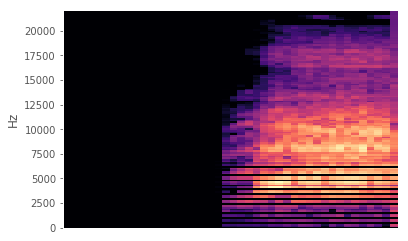

(14019, 128, 44)
________________________________________________________________________________
Layer (type)              Output Shape              Param #     
spectrogram_1 (Spectrogra (None, 257, 44, 1)        263168      
Total params: 263,168
Trainable params: 0
Non-trainable params: 263,168
________________________________________________________________________________
Epoch 1/1
2/2 [==============================] - 0s 70ms/step - loss: 1167.3931
(1, 11025)


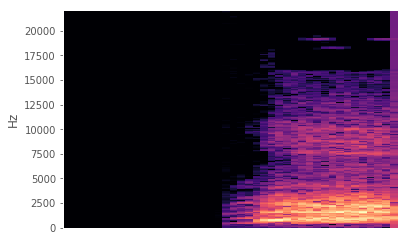

(14019, 257, 44)


In [16]:
import keras
import kapre
from keras.models import Sequential
from kapre.time_frequency import Melspectrogram, Spectrogram
from kapre.filterbank import Filterbank
import numpy as np

model = Sequential()
model.add(Melspectrogram(
    sr=44100,
    n_mels=128,
    power_melgram=2.0,
    return_decibel_melgram = True,
    input_shape=(1, blocksize),
    trainable_fb=False
))

check_model(model)
visualise_model(model, c_data[1])
mfccs = evaluate_model(model, c_data)

model = Sequential()
model.add(Spectrogram(
    return_decibel_spectrogram = True,
    input_shape=(1, blocksize)
))

check_model(model)
visualise_model(model, c_data[1])
spec = evaluate_model(model, c_data)

# Deep Net
Separate into classes

In [17]:
import librosa

def preprocess(mel_spec, spec):
    # Calculate the first 13 mfcc's
    mfccs = librosa.feature.mfcc(S=mel_spec, n_mfcc=13)
    # Get first derivative of the mfccs
    delta = librosa.feature.delta(mfccs)
    # Get second derivative of mfccs
    delta_2 = librosa.feature.delta(mfccs, order=2)
    
    spec_contrast = librosa.feature.spectral_contrast(S=spec)
    
    return np.vstack((mfccs[1:], delta, delta_2, spec_contrast)).transpose()

In [18]:
a_mfcc = mfccs[targets == 0]
a_spec = spec[targets == 0]
a_targ = c_targets[targets == 0]
i_mfcc = mfccs[targets == 1]
i_spec = spec[targets == 1]
i_targ = c_targets[targets == 1]

In [19]:
start_time = time.time()

new_dat = []
for i in range(0, a_spec.shape[0]):
    new_dat.append(preprocess(a_mfcc[i], a_spec[i]))

print(new_dat[0].shape)
print("\tProcessing Time: " + str(time.time() - start_time))

(44, 45)
	Processing Time: 30.80119776725769


In [20]:
new_dat = np.average(new_dat, axis=1)
print(new_dat.shape)

(5171, 45)


In [21]:
new_dat = np.vstack(new_dat)
print(new_dat.shape)

(5171, 45)


In [22]:
print(a_targ.shape)

(5171,)


# Animal Sounds

In [23]:
train_X, test_X, train_y, test_y = train_test_split(
                        new_dat, a_targ, test_size=0.20, random_state=56)

In [24]:
from keras.layers import Dense, Dropout

def gpu_mfcc_deep_net_a():
    # Create Model
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=(45,)))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(19, kernel_initializer='normal', activation='softmax'))
    
    # Compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    model.summary()

    
    return model

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

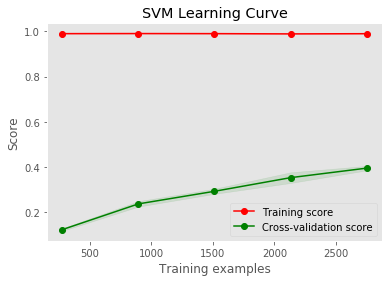

In [25]:
anim = SVC(gamma='auto', verbose=True)
plot_learning_curve(anim, 'SVM Learning Curve', train_X, train_y).show()

In [26]:
anim.fit(train_X, train_y)

[LibSVM]

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=True)

0.4454106280193237
Confusion matrix, without normalization
[[ 6  0  0  0  0  0  0  0  0  0  0  0 45  2  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0  0  0 40  1  0  0  0  0  0]
 [ 0  0 39  0  0  0  0  0  0  0  0  0 16  0  0  0  0  0  0]
 [ 0  0  0 20  0  0  0  0  0  0  0  0 41  3  0  0  0  0  0]
 [ 0  0  0  0 12  0  0  0  0  0  0  0 36  0  0  0  0  0  0]
 [ 0  0  0  1  0 23  0  0  0  0  0  0 23  2  0  0  0  0  0]
 [ 0  0  0  0  0  0 26  0  0  0  0  0 30  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0 30  0  0  0  0 17  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 27  0  0  0 51  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 23  0  0 35  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 58  0 15  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 21 41  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 59  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 11 16  0  0  2  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 19  0 39  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 33 

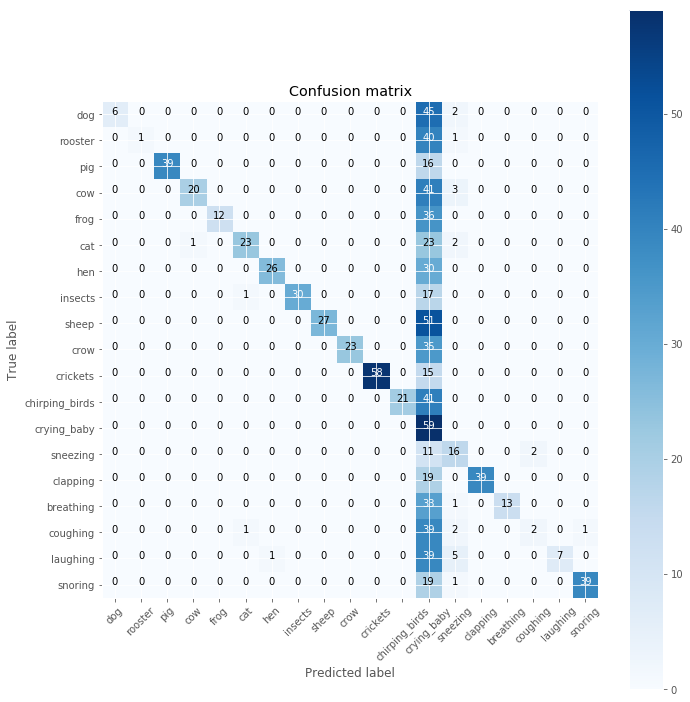

In [27]:
pred = anim.predict(test_X)
print(metrics.accuracy_score(test_y, pred))
cm = metrics.confusion_matrix(test_y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, names_a)
plt.show()

# Interacting Materials

In [28]:
start_time = time.time()

new_dat = []
for i in range(0, i_spec.shape[0]):
    new_dat.append(preprocess(i_mfcc[i], i_spec[i]))

print(new_dat[0].shape)
print("\tProcessing Time: " + str(time.time() - start_time))

(44, 45)
	Processing Time: 56.628190994262695


In [29]:
new_dat = np.average(new_dat, axis=1)
print(new_dat.shape)

(8848, 45)


In [30]:
print(i_targ.shape)

(8848,)


In [31]:
train_X, test_X, train_y, test_y = train_test_split(
                        new_dat, i_targ, test_size=0.20, random_state=75)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

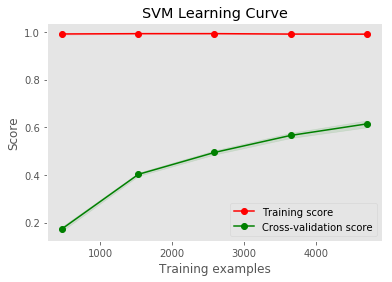

In [33]:
inter = SVC(gamma='auto', verbose=True)
plot_learning_curve(inter, 'SVM Learning Curve', train_X, train_y).show()

In [34]:
inter.fit(train_X, train_y)

[LibSVM]

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=True)

0.6717514124293785
Confusion matrix, without normalization
[[54  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  4  0  0  0]
 [ 0 52  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0 10  0  0  0]
 [ 0  0 43  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0 15  0  0  0]
 [ 0  0  0 21  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  1  0  0  0  0
   0  0  0 22  0  0  0]
 [ 0  0  0  0 67  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  2  0  0  0]
 [ 0  0  0  1  0  5  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0
   0  0  0 35  0  0  0]
 [ 0  0  0  0  0  0 37  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0
   0  0  0 14  0  0  0]
 [ 0  0  0  0  0  0  0 52  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  8  0  0  0]
 [ 0  0  0  0  0  0  0  0 27  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0 22  0  1  1]
 [ 0  0  0  0  0  0  0  0  0 26  0  0  0  0  0  0  0  0  1 

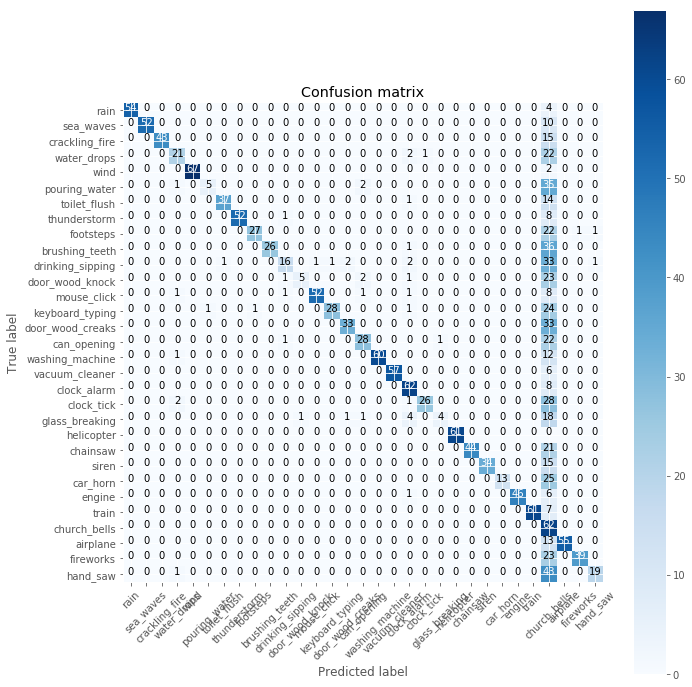

In [35]:
pred = inter.predict(test_X)
print(metrics.accuracy_score(test_y, pred))
cm = metrics.confusion_matrix(test_y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, names_i)
plt.show()

# All Data

In [36]:
X2, y2, yy2 = load_fold_audio_blockwise(2, dataset, blocksize, overlap)
X3, y3, yy3 = load_fold_audio_blockwise(3, dataset, blocksize, overlap)
X4, y4, yy4 = load_fold_audio_blockwise(4, dataset, blocksize, overlap)
X5, y5, yy5 = load_fold_audio_blockwise(5, dataset, blocksize, overlap)

	Processing Time: 7.632345199584961
	Processing Time: 7.107919454574585
	Processing Time: 6.567235946655273
	Processing Time: 6.6491899490356445


In [37]:
X = np.vstack((X2, X3, X4, X5))
print(X.shape)

(56774, 1, 11025)


In [38]:
y = np.concatenate((y2, y3, y4, y5))
print(y.shape)

(56774,)


In [39]:
yy = np.concatenate((yy2, yy3, yy4, yy5))
print(yy.shape)

(56774,)


In [ ]:
model = Sequential()
model.add(Melspectrogram(
    sr=44100,
    n_mels=128,
    power_melgram=2.0,
    return_decibel_melgram = True,
    input_shape=(1, blocksize),
    trainable_fb=False
))

check_model(model)
visualise_model(model, X[1])
mfccs = evaluate_model(model, X)

model = Sequential()
model.add(Spectrogram(
    return_decibel_spectrogram = True,
    input_shape=(1, blocksize)
))

check_model(model)
visualise_model(model, X[1])
spec = evaluate_model(model, X)

In [41]:
a_mfcc = mfccs[y == 0]
a_spec = spec[y == 0]
a_targ = yy[y == 0]
i_mfcc = mfccs[y == 1]
i_spec = spec[y == 1]
i_targ = yy[y == 1]

In [42]:
start_time = time.time()

new_dat = []
for i in range(0, a_spec.shape[0]):
    new_dat.append(preprocess(a_mfcc[i], a_spec[i]))

print(new_dat[0].shape)
print("\tProcessing Time: " + str(time.time() - start_time))

start_time = time.time()

(44, 45)
	Processing Time: 155.79053020477295


In [43]:
new_dat = np.average(new_dat, axis=1)
print(new_dat.shape)

(21104, 45)


In [44]:
print(a_targ.shape)

(21104,)


0.06894427596664139
Confusion matrix, without normalization
[[   7    0    0    3    0    4    7    0    0    2    0    1  988   68
     0    0    4    6   17]
 [   4    0    0    4    0    3    4    0    0    5    0    0  702  143
     0    0    0   10   10]
 [   0    0   28    0    0    0    1    0    0    0    0    0 1044    3
     0    0    0    0    0]
 [   4    0    0    6    0    1    4    0    0    4    0    0 1078   13
     0    1    0    1    1]
 [   1    0    0    0    0    0    0    0    0    0    0    0 1242    1
     0    0    0    0    0]
 [   6    0    0    4    0    2    1    0    0    1    0    0  968   22
     0    0    4    3   18]
 [   0    0    0    1    0    0    2    0    0    0    0    0 1130    9
     0    1    2    0    8]
 [   1    0    0   11    0    0    0    0    0    0    0    0 1193    5
     0    0    0    0    1]
 [   1    0    0    0    0    0    2    0    0    0    0    0 1230    1
     0    0    0    0    0]
 [   0    0    0    0    0    0    0    

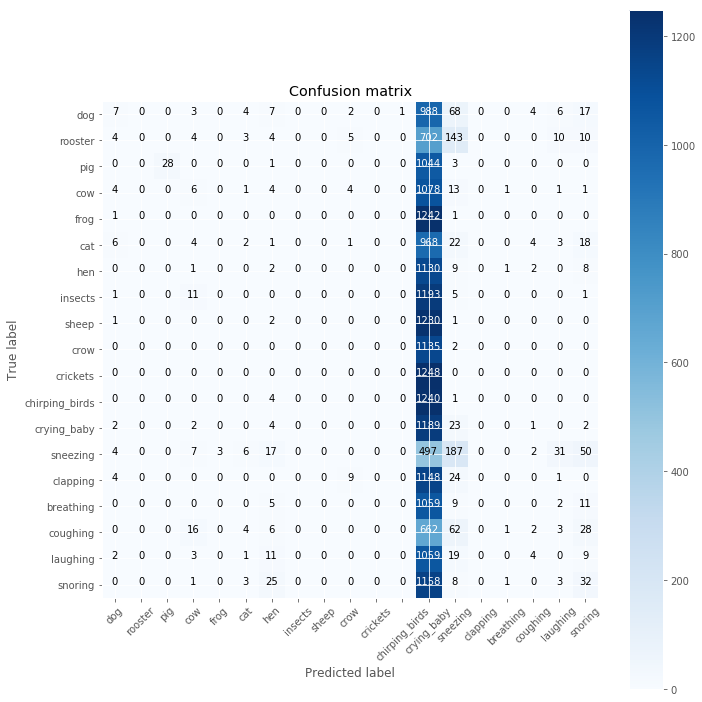

In [45]:
pred = anim.predict(new_dat)
print(metrics.accuracy_score(a_targ, pred))
cm = metrics.confusion_matrix(a_targ, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, names_a)
plt.show()

In [46]:
start_time = time.time()

new_dat = []
for i in range(0, i_spec.shape[0]):
    new_dat.append(preprocess(i_mfcc[i], i_spec[i]))

print(new_dat[0].shape)
print("\tProcessing Time: " + str(time.time() - start_time))

start_time = time.time()

(44, 45)
	Processing Time: 313.86060094833374


In [47]:
new_dat = np.average(new_dat, axis=1)
print(new_dat.shape)

(35670, 45)


In [48]:
print(i_targ.shape)

(35670,)


0.04463134286515279
Confusion matrix, without normalization
[[   0    0    0    0    0    0    0    0    0    1    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0 1247
     0    0    0]
 [   0    0    0    1    0    0    2    0    0    0    0    0    0    0
     1    1    0    0    5    2    0    0    0    0    0    0    0 1229
     0    0    1]
 [   0    0    0    1    0    0    0    0    0    0    2    0    0    0
     8    0    0    0    1    0    0    0    0    0    0    0    0 1190
     0   12    0]
 [   0    0    0    6    0   14   16   13    2    0   23    3    1    1
    58   19    0    0   40    9   10    0    0    0    0    0    0  789
     0   24    4]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0 1248
     0    0    0]
 [   0    0    0    3    0   11    0    0    0    1    5    0    1    0
     6   10    0    0   40   10    4    0    0    0    0  

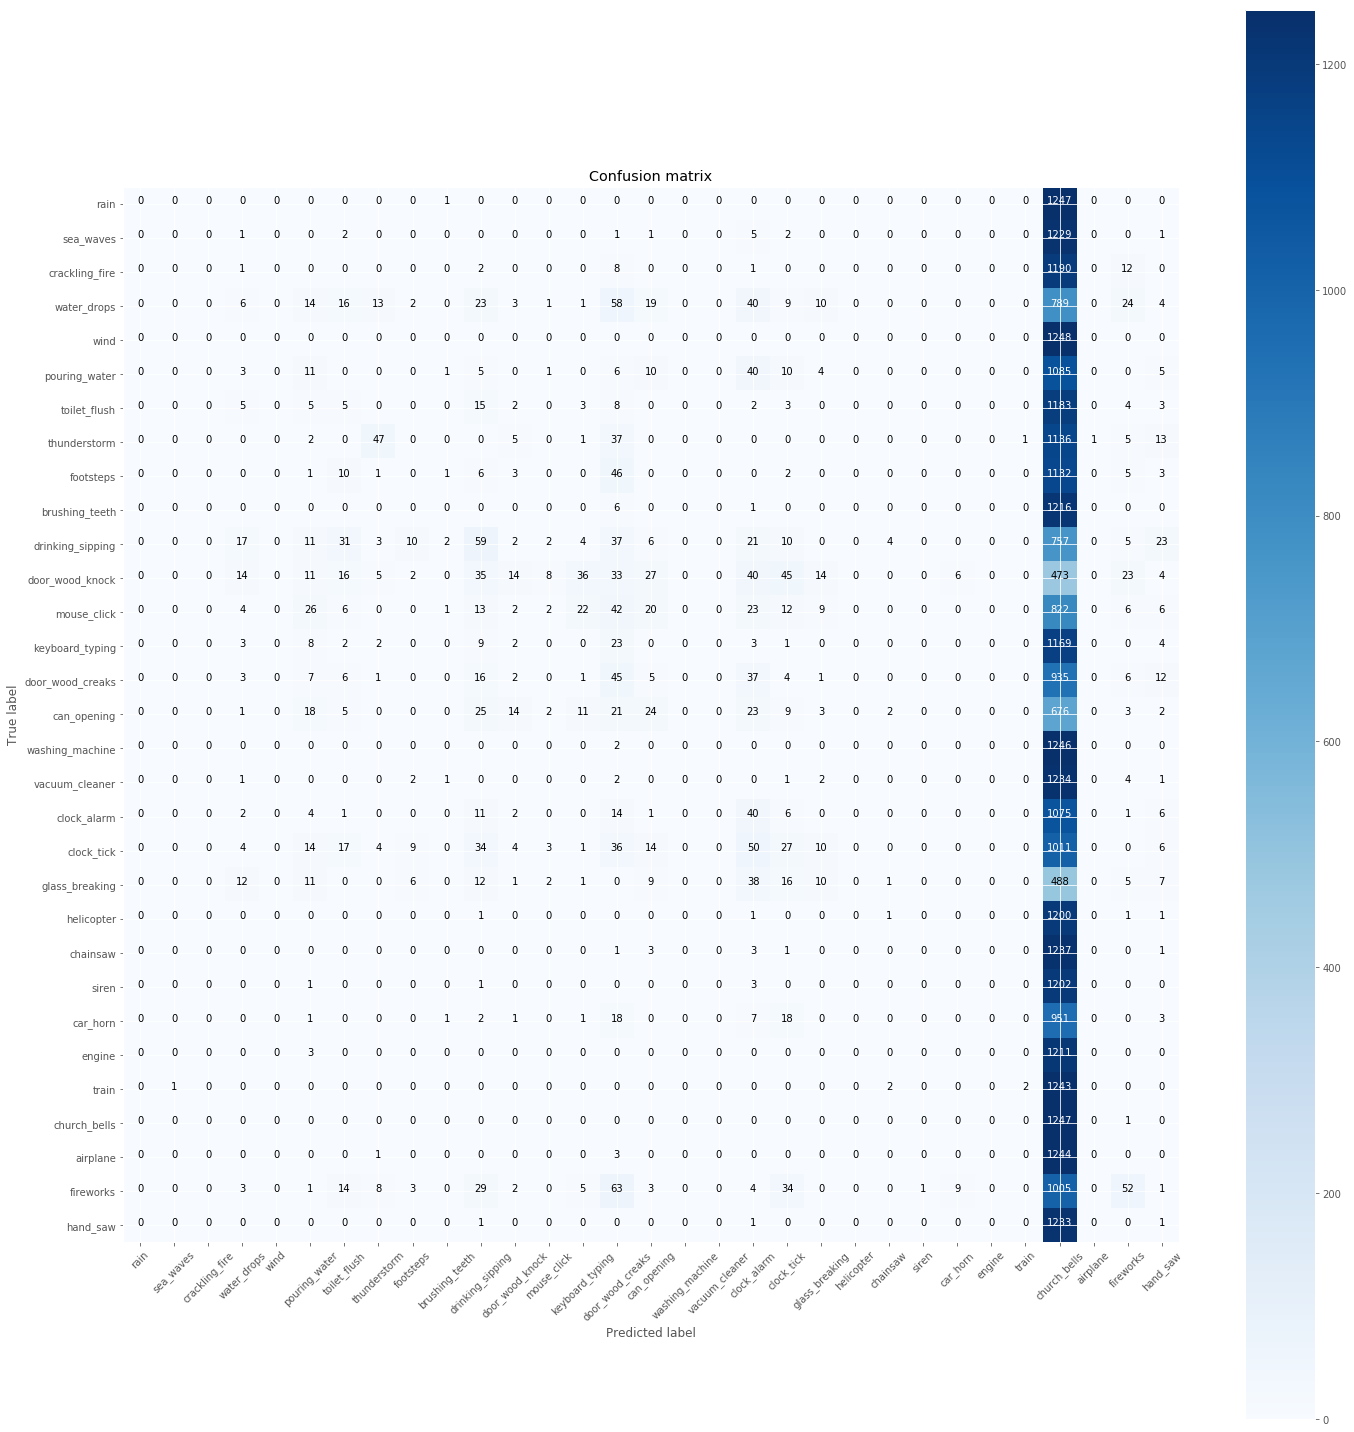

In [49]:
pred = inter.predict(new_dat)
print(metrics.accuracy_score(i_targ, pred))
cm = metrics.confusion_matrix(i_targ, pred)
plt.figure(figsize=(20,20))
plot_confusion_matrix(cm, names_i)
plt.show()